# Grounding and Pragmatics

The final homework for Berkeley CS288 will cover language grounding and pragmatics. We'll focus on a simple reference game domain known as [Colors in Context](https://arxiv.org/abs/1703.10186). Clasically, reference games involve two players, a speaker and a listener. Both players see a shared set of *referents* and the speaker is given a target reference which they must describe to the listener in the presence of distractors. For example, consider the image captioning task below, taken from the paper [Reasoning about Pragmatics with Neural Listeners and Speakers](https://aclanthology.org/D16-1125.pdf) by Jacob Andreas and Dan Klein:

![Screen Shot 2022-04-29 at 10.21.47 PM.png](attachment:ac932fdb-ca78-49aa-8f74-ca0d3da5add8.png)

We'll focus on a much simpler reference game in which images are replaced with colors. Your task will be to build a language generation model (speaker) which describes a color in the context of distractor colors, as well as a language understanding model (listener) which predicts a color given an utterance. The vast majority of the stencil code is provided for you in this homework.

Code from this notebook is attributable to Stanford CS224U, taught by Christopher Potts.

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
import cmath
import colorsys
import copy
import csv
import itertools
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
import nltk
import numpy as np
import os
import pandas as pd
import random
import string
import torch
import torch.nn as nn
import torch.utils.data
import sys

from collections import Counter, defaultdict
from itertools import product
from nltk.stem import PorterStemmer, WordNetLemmatizer 
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, train_test_split

In [3]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

## Dataset: Colors in Context

[Colors in Context](https://arxiv.org/abs/1703.10186) is a reference game dataset developed by Will Monroe, Robert XD Hawkins, Noah Goodman, and Christopher Potts. It contains color swatches paired with English language annotations for a target swatch, although [supplementary data in Mandarin also exists](https://aclanthology.org/N18-1196.pdf). In this notebook, we'll focus only on a subset of the English data. The following code is used for visualizing sample data and can be safely ignored:

In [4]:
TURN_BOUNDARY =  " ### "

class ColorsCorpusReader:
    """
    Basic interface for the Stanford Colors in Context corpus:
    https://cocolab.stanford.edu/datasets/colors.html
    Parameters
    ----------
    src_filename : str
        Full path to the corpus file.
    word_count : int or None
        If int, then only examples with `word_count` words in their
        'contents' field are included (as estimated by the number of
        whitespqce tokens). If None, then all examples are returned.
    normalize_colors : bool
         The colors in the corpus are in HLS format with values
         [0, 360], [0, 100], [0, 100]. If `normalize_colors=True`,
         these are scaled into [0, 1], [0, 1], [0, 1].
    Usage
    -----
    corpus = ColorsCorpusReader('filteredCorpus.csv')
    for ex in corpus.read():
        # ...
    """
    def __init__(self, src_filename, word_count=None, normalize_colors=True):
        self.src_filename = src_filename
        self.word_count = word_count
        self.normalize_colors = normalize_colors

    def read(self):
        """
        The main interface to the corpus.
        As in the paper, turns taken in the same game and round are
        grouped together into a single `ColorsCorpusExample` instance
        with the turn texts separated by `TURN_BOUNDARY`, formatted
        as a string.
        Yields
        ------
        `ColorsCorpusExample` with the `normalize_colors` attribute set
        as in `self.normalize_colors` in this class.
        """
        grouped = defaultdict(list)
        with open(self.src_filename) as f:
            reader = csv.DictReader(f)
            for row in reader:
                if row['role'] == 'speaker' and self._word_count_filter(row):
                    grouped[(row['gameid'], row['roundNum'])].append(row)
        for rows in grouped.values():
            yield ColorsCorpusExample(
                rows, normalize_colors=self.normalize_colors)

    def _word_count_filter(self, row):
        return self.word_count is None or \
          row['contents'].count(" ") == (self.word_count-1)


class ColorsCorpusExample:
    """
    Interface to individual examples in the Stanford Colors in
    Context corpus.
    Parameters
    ----------
    rows : list of dict
        This contains all of the turns associated with a given game
        and round. The assumption is that all of the key-value pairs
        in these dicts are the same except for the 'contents' key.
    normalize_colors : bool
         The colors in the corpus are in HLS format with values
         [0, 360], [0, 100], [0, 100]. If `normalize_colors=True`,
         these are scaled into [0, 1], [0, 1], [0, 1].
    Usage
    -----
    We assume that these instances are created by `ColorsCorpusReader`.
    For an example of one being created directly, see
    `test/test_colors.py::test_color_corpus_example`.
    Note
    ----
    There are values in the corpus that are present in `rows` but
    not captured in attributes right now, to keep this code from
    growing very complex. It should be straightforward to bring
    in these additional attributes by subclassing this class.
    """
    def __init__(self, rows, normalize_colors=True):
        self.normalize_colors = normalize_colors
        self.contents = TURN_BOUNDARY.join([r['contents'] for r in rows])
        # Make sure our assumptions about these rows are correct:
        self._check_row_alignment(rows)
        row = rows[0]
        self.gameid = row['gameid']
        self.roundNum = int(row['roundNum'])
        self.condition = row['condition']
        self.outcome = row['outcome'] == 'true'
        self.clickStatus = row['clickStatus']
        self.color_data = []
        for typ in ['click', 'alt1', 'alt2']:
            self.color_data.append({
                'type': typ,
                'Status': row['{}Status'.format(typ)],
                'rep': self._get_color_rep(row, typ),
                'speaker': int(row['{}LocS'.format(typ)]),
                'listener': int(row['{}LocL'.format(typ)])})
        self.colors = self._get_reps_in_order('Status')
        self.listener_context = self._get_reps_in_order('listener')
        self.speaker_context = self._get_reps_in_order('speaker')

    def parse_turns(self):
        """"
        Turns the `contents` string into a list by splitting on
        `TURN_BOUNDARY`.
        Returns
        -------
        list of str
        """
        return self.contents.split(TURN_BOUNDARY)

    def display(self, typ='model'):
        """
        Prints examples to the screen in an intuitive format: the
        utterance text appears first, following by the three color
        patches, with the target identified by a black border in the
        'speaker' and 'model' variants.
        Parameters
        ----------
        typ : str
            Should be 'model', 'speaker', or 'listener'. This
            determines the order the color patches are given. For
            'speaker' and 'listener', this is the order in the corpus.
            For 'model', it is a version with the two distractors
            printed in their canonical order and the target given last.
        Raises
        ------
        ValueError
            If `typ` isn't one of 'model', 'speaker', 'listener'.
        Prints
        ------
        text to standard output and three color patches as a
        `matplotlib.pyplot` image. For notebook usage, this should
        all embed nicely.
        """
        print(self.contents)
        if typ == 'model':
            colors = self.colors
            target_index = 2
        elif typ == 'listener':
            colors = self.listener_context
            target_index = None
        elif typ == 'speaker':
            colors = self.speaker_context
            target_index = self._get_target_index('speaker')
        else:
            raise ValueError('`typ` options: "model", "listener", "speaker"')

        rgbs = [self._convert_hls_to_rgb(*c) for c in colors]

        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3, 1))

        for i, c in enumerate(rgbs):
            ec = c if (i != target_index or typ == 'listener') else "black"
            patch = mpatch.Rectangle((0, 0), 1, 1, color=c, ec=ec, lw=8)
            axes[i].add_patch(patch)
            axes[i].axis('off')

    def _get_color_rep(self, row, typ):
        rep = []
        for dim in ['H', 'L', 'S']:
            colname = "{}Col{}".format(typ, dim)
            rep.append(float(row[colname]))
        if self.normalize_colors:
            rep = self._scale_color(*rep)
        return rep

    def _convert_hls_to_rgb(self, h, l, s):
        if not self.normalize_colors:
            h, l, s = self._scale_color(h, l, s)
        return colorsys.hls_to_rgb(h, l, s)

    @staticmethod
    def _scale_color(h, l, s):
        return [h/360, l/100, s/100]

    def _get_reps_in_order(self, field):
        colors = [(d[field], d['rep']) for d in self.color_data]
        return [rep for s, rep in sorted(colors)]

    def _get_target_index(self, field):
        for d in self.color_data:
            if d['Status'] == 'target':
                return d[field] - 1

    @staticmethod
    def _check_row_alignment(rows):
        """
        We expect all the dicts in `rows` to have the same keys and
        values except for the keys associated with the messages. This
        function tests this assumption holds.
        """
        keys = set(rows[0].keys())
        for row in rows[1:]:
            if set(row.keys()) != keys:
                raise RuntimeError(
                    "The dicts in the `rows` argument to `ColorsCorpusExample` "
                    "must have all the same keys.")
        exempted = {'contents', 'msgTime',
                    'numRawWords', 'numRawChars',
                    'numCleanWords', 'numCleanChars'}
        keys = keys - exempted
        for row in rows[1: ]:
            for key in keys:
                if rows[0][key] != row[key]:
                    raise RuntimeError(
                        "The dicts in the `rows` argument to `ColorsCorpusExample` "
                        "must have all the same key values except for the keys "
                        "associated with the message. The key {} has values {} "
                        "and {}".format(key, rows[0][key], row[key]))

    def __str__(self):
        return self.contents

In [5]:
# Load the data from Kaggle:
corpus = ColorsCorpusReader("colors.csv", word_count=None, normalize_colors=True)

In [6]:
# Compute size of corpus:
examples = list(corpus.read())
print("Number of datapoints: {}".format(len(examples)))

Number of datapoints: 20177


### Example Data

We'll visualize an example datapoint from the listener perspective. Can you guess which color is being referred to?

The darker blue one


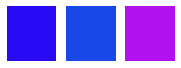

In [7]:
ex1 = next(corpus.read())
ex1.display(typ='listener')

We can see the answer by visualizing the datapoint from the speaker's perspective:

The darker blue one


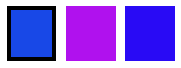

In [8]:
ex1 = next(corpus.read())
ex1.display(typ='speaker')

### Additional Details: Dataset Splits

Note that this dataset was constructed by generating colors under three separate conditions. In the "far" condition, the target color is not similar to either of the distractors. In the "split" condition, the target is similar to only one of the distractors. In the "close" condition, all three colors are similar to one another. We'll mostly ignore these splits in this homework, although you may wish to reference them in your report:

Condition type: far
purple


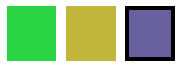

In [9]:
print("Condition type:", examples[1].condition)
examples[1].display()

Condition type: split
lime


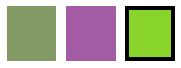

In [10]:
print("Condition type:", examples[3].condition)
examples[3].display()

Condition type: close
Medium pink ### the medium dark one


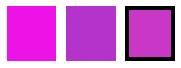

In [11]:
print("Condition type:", examples[2].condition)
examples[2].display()

In [12]:
pd.Series([ex.condition for ex in examples]).value_counts()

far      6785
split    6738
close    6654
dtype: int64

The dataset has some other features that we'll ignore in this work. For example, some data was collected over multiple iterations of dialogue, and the `parse_turns` function defined above can be used to process this type of language data. We'll ignore these complications in our work and focus on building relatively straightforward speaker and listener models.

## Helper Functions and Training Loop

The following code defines some helper functions and classes for training Pytorch models. Most of the following code is fairly boilerplat and similar to what you've seen in other assignments throughout this course. You do not need to write any code for this section.

In [13]:
START_SYMBOL = "<s>"
END_SYMBOL = "</s>"
UNK_SYMBOL = "$UNK"

In [14]:
def progress_bar(msg, verbose=True):
    # Simple over-writing progress bar.
    if verbose:
        sys.stderr.write('\r')
        sys.stderr.write(msg)
        sys.stderr.flush()
        
def randvec(n=50, lower=-0.5, upper=0.5):
    # Returns a random vector of length `n`. `w` is ignored.
    return np.array([random.uniform(lower, upper) for i in range(n)])

In [15]:
class TorchModelBase:
    def __init__(self,
            batch_size=1028,
            max_iter=1000,
            eta=0.001,
            optimizer_class=torch.optim.Adam,
            l2_strength=0,
            gradient_accumulation_steps=1,
            max_grad_norm=None,
            warm_start=False,
            early_stopping=False,
            validation_fraction=0.1,
            shuffle_train=True,
            n_iter_no_change=10,
            tol=1e-5,
            device=None,
            display_progress=True,
            **optimizer_kwargs):
        """
        Base class for all the PyTorch-based models.

        Parameters
        ----------
        batch_size: int
            Number of examples per batch. Batching is handled by a
            `torch.utils.data.DataLoader`. Final batches can have fewer
            examples, depending on the total number of examples in the
            dataset.

        max_iter: int
            Maximum number of training iterations. This will interact
            with `early_stopping`, `n_iter_no_change`, and `tol` in the
            sense that this limit will be reached if and only if and
            conditions triggered by those other parameters are not met.

        eta : float
            Learning rate for the optimizer.

        optimizer_class: `torch.optimizer.Optimizer`
            Any PyTorch optimizer should work. Additional arguments
            can be passed to this object via `**optimizer_kwargs`. The
            optimizer itself is built by `self.build_optimizer` when
            `fit` is called.

        l2_strength: float
            L2 regularization parameters for the optimizer. The default
            of 0 means no regularization, and larger values correspond
            to stronger regularization.

        gradient_accumulation_steps: int
            Controls how often the model parameters are updated during
            learning. For example, with `gradient_accumulation_steps=2`,
            the parameters are updated after every other batch. The primary
            use case for `gradient_accumulation_steps > 1` is where the
            model is very large, so only small batches of examples can be
            fit into memory. The updates based on these small batches can
            have high variance, so accumulating a few batches before
            updating can smooth the process out.

        max_grad_norm: None or float
            If not `None`, then `torch.nn.utils.clip_grad_norm_` is used
            to clip all the model parameters to within the range set
            by this value. This is a kind of brute-force way of keeping
            the parameter values from growing absurdly large or small.

        warm_start: bool
            If `False`, then repeated calls to `fit` will reset all the
            optimization settings: the model parameters, the optimizer,
            and the metadata we collect during optimization. If `True`,
            then calling `fit` twice with `max_iter=N` should be the same
            as calling fit once with `max_iter=N*2`.

        early_stopping: bool
            If `True`, then `validation_fraction` of the data given to
            `fit` are held out and used to assess the model after every
            epoch. The best scoring model is stored in an attribute
            `best_parameters`. If an improvement of at least `self.tol`
            isn't seen after `n_iter_no_change` iterations, then training
            stops and `self.model` is set to use `best_parameters`.

        validation_fraction: float
            Percentage of the data given to `fit` to hold out for use in
            early stopping. Ignored if `early_stopping=False`

        shuffle_train: bool
            Whether to shuffle the training data.

        n_iter_no_change: int
            Number of epochs used to control convergence and early
            stopping. Where `early_stopping=True`, training stops if an
            improvement of more than `self.tol` isn't seen after this
            many epochs. If `early_stopping=False`, then training stops
            if the epoch error doesn't drop by at least `self.tol` after
            this many epochs.

        tol: float
            Value used to control `early_stopping` and convergence.

        device: str or None
            Used to set the device on which the PyTorch computations will
            be done. If `device=None`, this will choose a CUDA device if
            one is available, else the CPU is used.

        display_progress: bool
            Whether to print optimization information incrementally to
            `sys.stderr` during training.

        **optimizer_kwargs: kwargs
            Any additional keywords given to the model will be passed to
            the optimizer -- see `self.build_optimizer`. The intent is to
            make it easy to tune these as hyperparameters will still
            allowing the user to specify just `optimizer_class` rather
            than setting up a full optimizer.

        Attributes
        ----------
        params: list
             All the keyword arguments are parameters and, with the
             exception of `display_progress`, their names are added to
             this list to support working with them using tools from
             `sklearn.model_selection`.

        """
        self.batch_size = batch_size
        self.max_iter = max_iter
        self.eta = eta
        self.optimizer_class = optimizer_class
        self.l2_strength = l2_strength
        self.gradient_accumulation_steps = max([gradient_accumulation_steps, 1])
        self.max_grad_norm = max_grad_norm
        self.warm_start = warm_start
        self.early_stopping = early_stopping
        self.validation_fraction = validation_fraction
        self.shuffle_train = shuffle_train
        self.n_iter_no_change = n_iter_no_change
        self.tol = tol
        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = torch.device(device)
        self.display_progress = display_progress
        self.optimizer_kwargs = optimizer_kwargs
        for k, v in self.optimizer_kwargs.items():
            setattr(self, k, v)
        self.params = [
            'batch_size',
            'max_iter',
            'eta',
            'optimizer_class',
            'l2_strength',
            'gradient_accumulation_steps',
            'max_grad_norm',
            'validation_fraction',
            'early_stopping',
            'n_iter_no_change',
            'warm_start',
            'tol']
        self.params += list(optimizer_kwargs.keys())

    def build_dataset(self, *args, **kwargs):
        """
        Subclasses are required to define this method. Perhaps the most
        important design note is that the function should be prepared to
        return datasets that are appropriate for both training and
        prediction. For training, we expect `*args` to have labels in
        final position. For prediction, we expect all of `*args` to be
        model inputs. For example, in a simple classifier, we expect
        `*args` to be a pair `(X, y)` for training and so this method
        should return something like:

        `torch.utils.data.TensorDataset(X, y)`

        For prediction, we get only `X`, so we should return

        `torch.utils.data.TensorDataset(X)`

        Parameters
        ----------
        *args: any arguments to be used to create the dataset

        **kwargs: any desired keyword arguments

        Returns
        -------
        `torch.utils.data.Dataset` or a custom subclass thereof

        """
        raise NotImplementedError

    def build_graph(self, *args, **kwargs):
        """
        Build the core computational graph. This is called only after
        `fit` is called. The return value of this function becomes the
        the `self.model` attribute.

        Parameters
        ----------
        *args: any arguments to be used to create the dataset

        **kwargs: any desired keyword arguments

        Returns
        -------
        nn.Module or subclass thereof

        """
        raise NotImplementedError

    def score(self, *args):
        """
        Required by the `sklearn.model_selection` tools. This function
        needs to take the same arguments as `fit`. For `*args` is usually
        an `(X, y)` pair of features and labels, and `self.predict(X)`
        is called and then some kind of scoring function is used to
        compare those predictions with `y`. The return value should be
        some kind of appropriate score for the model in question.

        Notes
        -----
        For early stopping, we use this function to get scores and
        assume that larger scores are better. This would conflict with
        using, say, a mean-squared-error scoring function.

        """
        raise NotImplementedError

    def build_optimizer(self):
        """
        Builds the optimizer. This function is called only when `fit`
        is called.

        Returns
        -------
        torch.optimizer.Optimizer

        """
        return self.optimizer_class(
            self.model.parameters(),
            lr=self.eta,
            weight_decay=self.l2_strength,
            **self.optimizer_kwargs)

    def fit(self, *args):
        """
        Generic optimization method.

        Parameters
        ----------
        *args: list of objects
            We assume that the final element of args give the labels
            and all the preceding elements give the system inputs.
            For regular supervised learning, this is like (X, y), but
            we allow for models that might use multiple data structures
            for their inputs.

        Attributes
        ----------
        model: nn.Module or subclass thereof
            Set by `build_graph`. If `warm_start=True`, then this is
            initialized only by the first call to `fit`.

        optimizer: torch.optimizer.Optimizer
            Set by `build_optimizer`. If `warm_start=True`, then this is
            initialized only by the first call to `fit`.

        errors: list of float
            List of errors. If `warm_start=True`, then this is
            initialized only by the first call to `fit`. Thus, where
            `max_iter=5`, if we call `fit` twice with `warm_start=True`,
            then `errors` will end up with 10 floats in it.

        validation_scores: list
            List of scores. This is filled only if `early_stopping=True`.
            If `warm_start=True`, then this is initialized only by the
            first call to `fit`. Thus, where `max_iter=5`, if we call
            `fit` twice with `warm_start=True`, then `validation_scores`
            will end up with 10 floats in it.

        no_improvement_count: int
            Used to control early stopping and convergence. These values
            are controlled by `_update_no_improvement_count_early_stopping`
            or `_update_no_improvement_count_errors`.  If `warm_start=True`,
            then this is initialized only by the first call to `fit`. Thus,
            in that situation, the values could accumulate across calls to
            `fit`.

        best_error: float
           Used to control convergence. Smaller is assumed to be better.
           If `warm_start=True`, then this is initialized only by the first
           call to `fit`. It will be reset by
           `_update_no_improvement_count_errors` depending on how the
           optimization is proceeding.

        best_score: float
           Used to control early stopping. If `warm_start=True`, then this
           is initialized only by the first call to `fit`. It will be reset
           by `_update_no_improvement_count_early_stopping` depending on how
           the optimization is proceeding. Important: we currently assume
           that larger scores are better. As a result, we will not get the
           correct results for, e.g., a scoring function based in
           `mean_squared_error`. See `self.score` for additional details.

        best_parameters: dict
            This is a PyTorch state dict. It is used if and only if
            `early_stopping=True`. In that case, it is updated whenever
            `best_score` is improved numerically. If the early stopping
            criteria are met, then `self.model` is reset to contain these
            parameters before `fit` exits.

        Returns
        -------
        self

        """
        if self.early_stopping:
            args, dev = self._build_validation_split(
                *args, validation_fraction=self.validation_fraction)

        # Dataset:
        dataset = self.build_dataset(*args)
        dataloader = self._build_dataloader(dataset, shuffle=self.shuffle_train)

        # Set up parameters needed to use the model. This is a separate
        # function to support using pretrained models for prediction,
        # where it might not be desirable to call `fit`.
        self.initialize()

        # Make sure the model is where we want it:
        self.model.to(self.device)

        self.model.train()
        self.optimizer.zero_grad()

        for iteration in range(1, self.max_iter+1):

            epoch_error = 0.0

            for batch_num, batch in enumerate(dataloader, start=1):

                batch = [x.to(self.device, non_blocking=True) for x in batch]

                X_batch = batch[: -1]
                y_batch = batch[-1]

                batch_preds = self.model(*X_batch)

                err = self.loss(batch_preds, y_batch)

                if self.gradient_accumulation_steps > 1 and \
                  self.loss.reduction == "mean":
                    err /= self.gradient_accumulation_steps

                err.backward()

                epoch_error += err.item()

                if batch_num % self.gradient_accumulation_steps == 0 or \
                  batch_num == len(dataloader):
                    if self.max_grad_norm is not None:
                        torch.nn.utils.clip_grad_norm_(
                            self.model.parameters(), self.max_grad_norm)
                    self.optimizer.step()
                    self.optimizer.zero_grad()

            # Stopping criteria:

            if self.early_stopping:
                self._update_no_improvement_count_early_stopping(*dev)
                if self.no_improvement_count > self.n_iter_no_change:
                    progress_bar(
                        "Stopping after epoch {}. Validation score did "
                        "not improve by tol={} for more than {} epochs. "
                        "Final error is {}".format(iteration, self.tol,
                            self.n_iter_no_change, epoch_error),
                        verbose=self.display_progress)
                    break

            else:
                self._update_no_improvement_count_errors(epoch_error)
                if self.no_improvement_count > self.n_iter_no_change:
                    progress_bar(
                        "Stopping after epoch {}. Training loss did "
                        "not improve more than tol={}. Final error "
                        "is {}.".format(iteration, self.tol, epoch_error),
                        verbose=self.display_progress)
                    break

            progress_bar(
                "Finished epoch {} of {}; error is {}".format(
                    iteration, self.max_iter, epoch_error),
                verbose=self.display_progress)

        if self.early_stopping:
            self.model.load_state_dict(self.best_parameters)

        return self

    def initialize(self):
        """
        Method called by `fit` to establish core attributes. To use a
        pretrained model without calling `fit`, one can use this
        method.

        """
        if not self.warm_start or not hasattr(self, "model"):
            self.model = self.build_graph()
            # This device move has to happen before the optimizer is built:
            # https://pytorch.org/docs/master/optim.html#constructing-it
            self.model.to(self.device)
            self.optimizer = self.build_optimizer()
            self.errors = []
            self.validation_scores = []
            self.no_improvement_count = 0
            self.best_error = np.inf
            self.best_score = -np.inf
            self.best_parameters = None

    @staticmethod
    def _build_validation_split(*args, validation_fraction=0.2):
        """
        Split `*args` into train and dev portions for early stopping.
        We use `train_test_split`. For args of length N, then delivers
        N*2 objects, arranged as

        X1_train, X1_test, X2_train, X2_test, ..., y_train, y_test

        Parameters
        ----------
        *args: List of objects to split.

        validation_fraction: float
            Percentage of the examples to use for the dev portion. In
            `fit`, this is determined by `self.validation_fraction`.
            We give it as an argument here to facilitate unit testing.

        Returns
        -------
        Pair of tuples `train` and `dev`

        """
        if validation_fraction == 1.0:
            return args, args
        results = train_test_split(*args, test_size=validation_fraction)
        train = results[::2]
        dev = results[1::2]
        return train, dev

    def _build_dataloader(self, dataset, shuffle=True):
        """
        Internal method used to create a dataloader from a dataset.
        This is used by `fit` and `_predict`.

        Parameters
        ----------
        dataset: torch.utils.data.Dataset

        shuffle: bool
            When training, this is `True`. For prediction, this is
            crucially set to `False` so that the examples are not
            shuffled out of order with respect to labels that might
            be used for assessment.

        Returns
        -------
        torch.utils.data.DataLoader

        """
        if hasattr(dataset, "collate_fn"):
            collate_fn = dataset.collate_fn
        else:
            collate_fn = None
        dataloader = torch.utils.data.DataLoader(
            dataset,
            batch_size=self.batch_size,
            shuffle=shuffle,
            pin_memory=True,
            collate_fn=collate_fn)
        return dataloader

    def _update_no_improvement_count_early_stopping(self, *dev):
        """
        Internal method used by `fit` to control early stopping.
        The method uses `self.score(*dev)` for scoring and updates
        `self.validation_scores`, `self.no_improvement_count`,
        `self.best_score`, `self.best_parameters` as appropriate.

        """
        score = self.score(*dev)
        self.validation_scores.append(score)
        # If the score isn't at least `self.tol` better, increment:
        if score < (self.best_score + self.tol):
            self.no_improvement_count += 1
        else:
            self.no_improvement_count = 0
        # If the current score is numerically better than all previous
        # scores, update the best parameters:
        if score > self.best_score:
            self.best_parameters = copy.deepcopy(self.model.state_dict())
            self.best_score = score
        self.model.train()

    def _update_no_improvement_count_errors(self, epoch_error):
        """
        Internal method used by `fit` to control convergence.
        The method uses `epoch_error`, `self.best_error`, and
        `self.tol` to make decisions, and it updates `self.errors`,
        `self.no_improvement_count`, and `self.best_error` as
        appropriate.

        """
        if epoch_error > (self.best_error - self.tol):
            self.no_improvement_count += 1
        else:
            self.no_improvement_count = 0
        if epoch_error < self.best_error:
            self.best_error = epoch_error
        self.errors.append(epoch_error)

    def _predict(self, *args, device=None):
        """
        Internal method that subclasses are expected to use to define
        their own `predict` functions. The hope is that this method
        can do all the data organization and other details, allowing
        subclasses to have compact predict methods that just encode
        the core logic specific to them.

        Parameters
        ----------
        *args: system inputs

        device: str or None
            Allows the user to temporarily change the device used
            during prediction. This is useful if predictions require a
            lot of memory and so are better done on the CPU. After
            prediction is done, the model is returned to `self.device`.

        Returns
        -------
        The precise return value depends on the nature of the predictions.
        If the predictions have the same shape across all batches, then
        we return a single tensor concatenation of them. If the shape
        can vary across batches, as is common for sequence prediction,
        then we return a list of tensors of varying length.

        """
        device = self.device if device is None else torch.device(device)

        # Dataset:
        dataset = self.build_dataset(*args)
        dataloader = self._build_dataloader(dataset, shuffle=False)

        # Model:
        self.model.to(device)
        self.model.eval()

        preds = []
        with torch.no_grad():
            for batch in dataloader:
                X = [x.to(device, non_blocking=True) for x in batch]
                preds.append(self.model(*X))

        # Make sure the model is back on the instance device:
        self.model.to(self.device)

        # If the batch outputs differ only in their batch size, sharing
        # all other dimensions, then we can concatenate them and maintain
        # a tensor. For simple classification problems, this should hold.
        if all(x.shape[1: ] == preds[0].shape[1: ] for x in preds[1: ]):
            return torch.cat(preds, axis=0)
        # The batch outputs might differ along other dimensions. This is
        # common for sequence prediction, where different batches might
        # have different max lengths, since we pad on a per-batch basis.
        # In this case, we can't concatenate them, so we return a list
        # of the predictions, where each prediction is a tensor. Note:
        # the predictions might still be padded and so need trimming on a
        # per example basis.
        else:
            return [p for batch in preds for p in batch]

    def get_params(self, deep=True):
        params = self.params.copy()
        # Obligatorily add `vocab` so that sklearn passes it in when
        # creating new model instances during cross-validation:
        if hasattr(self, 'vocab'):
            params += ['vocab']
        return {p: getattr(self, p) for p in params}

    def set_params(self, **params):
        for key, val in params.items():
            if key not in self.params:
                raise ValueError(
                    "{} is not a parameter for {}. For the list of "
                    "available parameters, use `self.params`.".format(
                        key, self.__class__.__name__))
            else:
                setattr(self, key, val)
        return self

    def to_pickle(self, output_filename):
        """
        Serialize the entire class instance. Importantly, this is
        different from using the standard `torch.save` method:

        torch.save(self.model.state_dict(), output_filename)

        The above stores only the underlying model parameters. In
        contrast, the current method ensures that all of the model
        parameters are on the CPU and then stores the full instance.
        This is necessary to ensure that we retain all the information
        needed to read new examples, do additional training, make
        predictions, and so forth.

        Parameters
        ----------
        output_filename : str
            Full path for the output file.

        """
        self.model = self.model.cpu()
        with open(output_filename, 'wb') as f:
            pickle.dump(self, f)

    @staticmethod
    def from_pickle(src_filename):
        """
        Load an entire class instance onto the CPU. This also sets
        `self.warm_start=True` so that the loaded parameters are used
        if `fit` is called.

        Importantly, this is different from recommended PyTorch method:

        self.model.load_state_dict(torch.load(src_filename))

        We cannot reliably do this with new instances, because we need
        to see new examples in order to set some of the model
        dimensionalities and obtain information about what the class
        labels are. Thus, the current method loads an entire serialized
        class as created by `to_pickle`.

        The training and prediction code move the model parameters to
        `self.device`.

        Parameters
        ----------
        src_filename : str
            Full path to the serialized model file.

        """
        with open(src_filename, 'rb') as f:
            return pickle.load(f)

    def __repr__(self):
        param_str = ["{}={}".format(a, getattr(self, a)) for a in self.params]
        param_str = ",\n\t".join(param_str)
        return "{}(\n\t{})".format(self.__class__.__name__, param_str)

In [16]:
class ColorDataset(torch.utils.data.Dataset):
    """
    PyTorch dataset for contextual color describers. The primary
    function of this dataset is to organize the raw data into
    batches of Tensors of the appropriate shape and type. When
    using this dataset with `torch.utils.data.DataLoader`, it is
    crucial to supply the `collate_fn` method as the argument for
    the `DataLoader.collate_fn` parameter.

    Parameters
    ----------
    color_seqs : list of lists of lists of floats, or np.array
        Dimension (m, n, p) where m is the number of examples, n is
        the number of colors in each context, and p is the length
        of the color representations.

    word_seqs : list of list of int
        Dimension m, the number of examples. The length of each
        sequence can vary.

    ex_lengths : list of int
        Dimension m. Each value gives the length of the corresponding
        word sequence in `word_seqs`.

    """
    def __init__(self, color_seqs, word_seqs, ex_lengths):
        assert len(color_seqs) == len(ex_lengths)
        assert len(color_seqs) == len(word_seqs)
        self.color_seqs = color_seqs
        self.word_seqs = word_seqs
        self.ex_lengths = ex_lengths

    @staticmethod
    def collate_fn(batch):
        """
        Function for creating batches.

        Parameter
        ---------
        batch : tuple of length 3
            Contains the `color_seqs`, `word_seqs`, and `ex_lengths`,
            all as lists or similar Python iterables. The function
            turns them into Tensors.

        Returns
        -------
        color_seqs : torch.FloatTensor.
             The shape is `(m, n, p)` where `m` is the batch_size,
             `n` is the number of colors in each context, and `p` is
             the color dimensionality.

        word_seqs : torch.LongTensor
            This is a padded sequence, dimension (m, k), where `m` is
            the batch_size and `k` is the length of the longest sequence
            in the batch.

        ex_lengths : torch.LongTensor
            The true lengths of each sequence in `word_seqs. This will
            have shape `(m, )`, where `m` is the batch_size.

        targets :  torch.LongTensor
            This is a padded sequence, dimension (m, k-1), where `m` is
            the batch_size and `k` is the length of the longest sequence
            in the batch. The targets match `word_seqs` except we drop the
            first symbol, as it is always START_SYMBOL. When the loss is
            calculated, we compare this sequence to `word_seqs` excluding
            the final character, which is always the END_SYMBOL. The result
            is that each timestep t is trained to predict the symbol
            at t+1.

        """
        color_seqs, word_seqs, ex_lengths = zip(*batch)
        # Conversion to Tensors:
        color_seqs = torch.FloatTensor(color_seqs)
        word_seqs = [torch.LongTensor(seq) for seq in word_seqs]
        ex_lengths = torch.LongTensor(ex_lengths)
        # Targets as next-word predictions:
        targets = [x[1:, ] for x in word_seqs]
        # Padding
        word_seqs = torch.nn.utils.rnn.pad_sequence(
            word_seqs, batch_first=True)
        targets = torch.nn.utils.rnn.pad_sequence(
            targets, batch_first=True)
        return color_seqs, word_seqs, ex_lengths, targets

    def __len__(self):
        return len(self.color_seqs)

    def __getitem__(self, idx):
        return self.color_seqs[idx], self.word_seqs[idx], self.ex_lengths[idx]

## Baseline Model

We'll implement the speaker model depicted on the right side of the diagram below. In this model, color representations are fed into an encoder LSTM, which is connected to a decoder LSTM that generates utterances conditioned on the color representation. The model described in Monroe, et al. (2017) concatenates the hidden representation of the encoder model with word representations during teacher-forcing; we will leave this part of the model as an optional extension as part of the report.

![Screen Shot 2022-04-29 at 11.12.04 PM.png](attachment:d5c3e6f8-0ba6-468c-b036-4883253ddeec.png)



### Encoder-Decoder 
We'll begin by defining the encoder and decoder models. You should only need to fill in a few lines of fairly straightforward code here: 

In [17]:
class Encoder(nn.Module):
    def __init__(self, color_dim, hidden_dim):
        """
        Simple Encoder model based on a GRU cell.
        ----------
        color_dim : int
        hidden_dim : int
        """
        super().__init__()
        self.color_dim = color_dim
        self.hidden_dim = hidden_dim
        """
        YOUR CODE HERE
          - Define a single-layer LSTM/GRU with dimensions as above
          - Set batch_first=True
        """
        # BEGIN SOLUTION
        self.lstm = nn.LSTM(color_dim,hidden_dim,batch_first=True)
        # END SOLUTION

    def forward(self, color_seqs):
        """
        Parameters
        ----------
        color_seqs : torch.FloatTensor
            The shape is `(m, n, p)` where `m` is the batch_size,
             `n` is the number of colors in each context, and `p` is
             the color dimensionality.

        Returns
        -------
        hidden : torch.FloatTensor
            These are the final hidden state of the RNN for this batch,
            shape `(m, p) where `m` is the batch_size and `p` is
             the color dimensionality.

        YOUR CODE HERE
          - Call the LSTM/GRU defined above
          - Return the hidden states and discard the output
        """
        # BEGIN SOLUTION
        out, hidden = self.lstm(color_seqs)
        # END SOLUTION
        return hidden

The decoder is similar to the encoder, with the addition of a dense output layer. You'll also need to use `pack_padded_sequence` and `pad_packed_sequence` during training. Note that our code handles all of the tensor operations like slicing and transposing, so you only need to pass your embeddings into a series of functions. You do not need to call `pack_padded_sequence` during inference.

In [18]:
from torch.nn.utils.rnn import pack_padded_sequence
class Decoder(nn.Module):
    def __init__(self,
            vocab_size,
            embed_dim,
            hidden_dim,
            embedding=None,
            freeze_embedding=False):
        """
        Simple Decoder model based on a GRU cell. The hidden
        representations of the GRU are passed through a dense linear
        layer, and those logits are used to train the language model
        according to a softmax objective in `ContextualColorDescriber`.

        Parameters
        ----------
        vocab_size : int

        embed_dim : int

        hidden_dim : int

        embedding : np.array or None
            If `None`, a random embedding is created. If `np.array`, this
            value becomes the embedding.

        """
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.freeze_embedding = freeze_embedding
        self.embedding = self._define_embedding(embedding, self.vocab_size, embed_dim, self.freeze_embedding)
        self.embed_dim = self.embedding.embedding_dim
        
        """
        YOUR CODE HERE
          - Define another single-layer LSTM/GRU
          - Add an output layer which maps onto self.vocab_size
        """
        # BEGIN SOLUTION
        self.lstm_d = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, vocab_size)
        # END SOLUTION

    def forward(self, word_seqs, seq_lengths=None, hidden=None, target_colors=None):
        """
        Core computation for the model.

        Parameters
        ----------
        word_seqs : torch.LongTensor
            This is a padded sequence, dimension (m, k), where k is
            the length of the longest sequence in the batch. The `forward`
            method uses `self.get_embeddings` to map these indices to their
            embeddings.

        seq_lengths : torch.LongTensor
            Shape (m, ) where `m` is the number of examples in the batch.

        hidden : torch.FloatTensor
            Shape `(m, self.hidden_dim)`. When training, this is always the
            final state of the `Encoder`. During prediction, this might be
            recursively computed as the sequence is processed.

        target_colors : torch.FloatTensor
            Dimension (m, c), where m is the number of examples and
            c is the dimensionality of the color representations.

        Returns
        -------
        output : torch.FloatTensor
            The full sequence of outputs states. When we are training, the
            shape is `(m, hidden_dim, k)` to accommodate the expectations
            of the loss function. During prediction, the shape is
            `(m, k, hidden_dim)`. In both cases, m is the number of examples in
            the batch and `k` is the maximum length of sequences in this batch.

        hidden : torch.FloatTensor
            The final output state of the network. Shape `(m, hidden_dim)`
            where m is the number of examples in the batch.

        """
        embs = self.get_embeddings(word_seqs, target_colors=target_colors)

        if self.training:
            """
            YOUR CODE HERE
              - Call pack_padded_sequence on embs
              - Feed embeddings and hidden state into the LSTM/GRU
              - Call pad_packed_sequence on the output
              - Feed output into a dense layer 
              - Remove the final prediction and reshape to match the loss function
            """
            # BEGIN SOLUTION
            embeds = pack_padded_sequence(embs,seq_lengths.to('cpu'), batch_first=True, enforce_sorted=False)
            output, hidden = self.lstm_d(embeds, hidden)
            
            output, _ = pad_packed_sequence(output, batch_first=True)
            output = self.linear(output)
            # END SOLUTION
            output = output[:, : -1, :]
            output = output.transpose(1, 2)
            return output, hidden
        else:
            """
            YOUR CODE HERE
              - Feed embeddings and hidden state into the LSTM/GRU
              - Feed output into a dense layer 
            """
            # BEGIN SOLUTION
            output, hidden = self.lstm_d(embs, hidden)
            output = self.linear(output)
            # END SOLUTION
            return output, hidden

    def get_embeddings(self, word_seqs, target_colors=None):
        """
        Gets the input token representations. At present, these are
        just taken directly from `self.embedding`, but `target_colors`
        can be made available in case the user wants to subclass this
        function to append these representations to each input token.

        Parameters
        ----------
        word_seqs : torch.LongTensor
            This is a padded sequence, dimension (m, k), where k is
            the length of the longest sequence in the batch.

        target_colors : torch.FloatTensor
            Dimension (m, c), where m is the number of examples and
            c is the dimensionality of the color representations.

        """
        return self.embedding(word_seqs)

    @staticmethod
    def _define_embedding(embedding, vocab_size, embed_dim, freeze_embedding):
        if embedding is None:
            emb = nn.Embedding(vocab_size, embed_dim)
            emb.weight.requires_grad = not freeze_embedding
            return emb
        else:
            embedding = torch.FloatTensor(embedding)
            return nn.Embedding.from_pretrained(
                embedding, freeze=freeze_embedding)

In [19]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        """
        This class knits the `Encoder` and `Decoder` into a single class
        that serves as the model for `ContextualColorDescriber`. This is
        largely a convenience: it means that `ContextualColorDescriber`
        can use a single `model` argument, and it allows us to localize
        the core computations in the `forward` method of this class.

        Parameters
        ----------
        encoder : `Encoder`

        decoder : `Decoder`

        """
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, color_seqs, word_seqs, seq_lengths, hidden=None):
        """This is the core method for this module. It has a lot of
        arguments mainly to make it easy to create subclasses of this
        class that do interesting things without requiring modifications
        to the `fit` method of `ContextualColorDescriber`.

        Parameters
        ----------
        color_seqs : torch.FloatTensor
            Dimension (m, n, p), where m is the number of examples,
            n is the number of colors in each context, and p is the
            dimensionality of each color.

        word_seqs : torch.LongTensor
            Dimension (m, k), where m is the number of examples and k
            is the length of all the (padded) sequences in the batch.

        seq_lengths : torch.LongTensor or None
            The true lengths of the sequences in `word_seqs`. If this
            is None, then we are predicting new sequences, so we will
            continue predicting until we hit a maximum length or we
            generate STOP_SYMBOL.

        hidden : torch.FloatTensor or None
            The hidden representation for each of the m examples in this
            batch. If this is None, we are predicting new sequences
            and so the hidden representation is computed for each timestep
            during decoding.

        Returns
        -------
        output : torch.FloatTensor
            Dimension (m, k, c), where m is the number of examples, k
            is the length of the sequences in this batch, and c is the
            number of classes (the size of the vocabulary).

        hidden : torch.FloatTensor
            Dimension (m, h) where m is the number of examples and h is
            the dimensionality of the hidden representations of the model.
            This value is returned only when the model is in eval mode.

        """
        if hidden is None:
            hidden = self.encoder(color_seqs)
        output, hidden = self.decoder(
            word_seqs, seq_lengths=seq_lengths, hidden=hidden)
        if self.training:
            return output
        else:
            return output, hidden

### Inference and Evaluation

Please read the following code closely, as it defines our evaluation criteria. Because exact match with our reference annotations is too stringent a criteria, we'll use a word-overlap metric (unigram BLEU). We also use a [pragmatic listener-based evaluation](https://arxiv.org/abs/1909.07290) defined as follows:

$$
\operatorname{L}(\text{utterance}, C) = \underset{c \in C}{\mathrm{argmax}}\,\operatorname{S}(\text{utterance} \mid c)
$$

where $c \in C$ is a color in the set of colors $C$ and $S$ is the speaker model defined above. This is a fundamentally *pragmatic* evaluation criteria because it models speaker's performance in terms of whether or not a listener could accurately infer their intended meaning. For more information about computational pragmatics, see [Goodman & Frank (2016)](https://www.sciencedirect.com/science/article/pii/S136466131630122X?casa_token=KQaBwc3jIDAAAAAA:hmyhXA3rxE7qRGILgoSS9erA17tPI7Az_6h2_TN1UmbuMemWKDJQxR6PaLkJ4woj_4zSg9ePN_I). Note that many other approaches to listener-based evaluation may use a cross-talk setting in which the listener is a separate agent trained on a different subset of data. As part of the experimentation for your report, you are welcome to explore this direction by building a separate listener agent.

Because the pragmatic listener is part of our evaluation criteria, we won't ask you to implement it. We will however ask that you write the inner loop of thet `predict` function, which calls `self.model` at each step of decoding.

In [20]:
class ContextualColorDescriber(TorchModelBase):
    def __init__(self,
            vocab,
            embedding=None,
            embed_dim=50,
            hidden_dim=50,
            freeze_embedding=False,
            **base_kwargs):
        """
        The primary interface to modeling contextual colors datasets.

        Parameters
        ----------
        vocab : list of str
            This should be the vocabulary. It needs to be aligned with
            `embedding` in the sense that the ith element of vocab
            should be represented by the ith row of `embedding`.
            
        embedding : np.array or None
            Each row represents a word in `vocab`, as described above.

        embed_dim : int
            Dimensionality for the initial embeddings. This is ignored
            if `embedding` is not None, as a specified value there
            determines this value.

        hidden_dim : int
            Dimensionality of the hidden layer.

        freeze_embedding : bool
            If True, the embedding will be updated during training. If
            False, the embedding will be frozen. This parameter applies
            to both randomly initialized and pretrained embeddings.

        **base_kwargs
            For details, see `torch_model_base.py`.

        Attributes
        ----------
        vocab_size : int

        word2index : dict
            A look-up from vocab items to their indices.

        index2word : dict
            A look-up for indices to vocab items.

        output_dim : int
            Same as `vocab_size`.

        start_index : int
            Index of START_SYMBOL in `self.vocab`.

        end_index : int
            Index of END_SYMBOL in `self.vocab`.

        unk_index : int
            Index of UNK_SYMBOL in `self.vocab`.

        loss: nn.CrossEntropyLoss(reduction="mean")

        self.params: list
            Extends TorchModelBase.params with names for all of the
            arguments for this class to support tuning of these values
            using `sklearn.model_selection` tools.

        """
        super().__init__(**base_kwargs)
        self.vocab = vocab
        self.hidden_dim = hidden_dim
        self.embedding = embedding
        self.freeze_embedding = freeze_embedding
        self.vocab_size = len(vocab)
        self.word2index = dict(zip(self.vocab, range(self.vocab_size)))
        self.index2word = dict(zip(range(self.vocab_size), self.vocab))
        self.embed_dim = embed_dim
        self.output_dim = self.vocab_size
        self.start_index = self.vocab.index(START_SYMBOL)
        self.end_index = self.vocab.index(END_SYMBOL)
        self.unk_index = self.vocab.index(UNK_SYMBOL)
        self.params += ['hidden_dim', 'embed_dim', 'embedding', 'freeze_embedding']
        self.loss = nn.CrossEntropyLoss()

    def build_dataset(self, color_seqs, word_seqs):
        """

        Create a dataset from a list of color contexts and
        associated utterances.

        Parameters:
        ----------
        color_seqs : list of lists of color representations
            We assume that each context has the same number of colors,
            each with the same shape.

        word_seqs : list of lists of utterances
            A tokenized list of words. This method uses `self.word2index`
            to turn this into a list of lists of indices.

        Returns
        -------
        ColorDataset

        """
        self.color_dim = len(color_seqs[0][0])
        word_seqs = [[self.word2index.get(w, self.unk_index) for w in seq]
                     for seq in word_seqs]
        ex_lengths = [len(seq) for seq in word_seqs]
        return ColorDataset(color_seqs, word_seqs, ex_lengths)

    def build_graph(self):
        """
        The core computation graph. This method is called by `fit` to set
        the `self.model` attribute.

        Returns
        -------
        `EncoderDecoder` built from `Encoder` and `Decoder`

        """
        encoder = Encoder(
            color_dim=self.color_dim,
            hidden_dim=self.hidden_dim)

        decoder = Decoder(
            vocab_size=self.vocab_size,
            embed_dim=self.embed_dim,
            embedding=self.embedding,
            hidden_dim=self.hidden_dim,
            freeze_embedding=self.freeze_embedding)

        self.embed_dim = decoder.embed_dim
        return EncoderDecoder(encoder, decoder)

    def predict(self, color_seqs, max_length=20, device=None):
        """
        Predict new sequences based on the color contexts in
        `color_seqs`.

        Parameters
        ----------
        color_seqs : list of lists of lists of floats, or np.array
            Dimension (m, n, p) where m is the number of examples, n is
            the number of colors in each context, and p is the length
            of the color representations.

        max_length : int
            Length of the longest sequences to create.

        device: str or None
            Allows the user to temporarily change the device used
            during prediction. This is useful if predictions require a
            lot of memory and so are better done on the CPU. After
            prediction is done, the model is returned to `self.device`.

        Returns
        -------
        list of str

        """
        device = self.device if device is None else torch.device(device)
        color_seqs = torch.FloatTensor(color_seqs)
        color_seqs = color_seqs.to(device)
        self.model.to(device)
        self.model.eval()
        preds = []

        with torch.no_grad():
            # Get the hidden representations from the color contexts:
            hidden = self.model.encoder(color_seqs)

            # Start with START_SYMBOL for all examples:
            decoder_input = [[self.start_index]] * len(color_seqs)
            decoder_input = torch.LongTensor(decoder_input)
            decoder_input = decoder_input.to(device)
            preds.append(decoder_input)

            
            """
            YOUR CODE HERE
              - Iterate until max_length is reached
              - At each iteration, feed your hidden states into self.model
              - Take the argmax of your output to get the highest probability token
              - Append this token to preds, and update your decoder_input
            """
            # BEGIN SOLUTION
            # Now move through the remaiming timesteps using the
            # previous timestep to predict the next one:
            for i in range(max_length):
              output, hidden = self.model.decoder(decoder_input, hidden=hidden, seq_lengths=None)
              output = torch.argmax(output, dim=-1)
              preds.append(output)
              decoder_input = output
            # END SOLUTION

        # Convert all the predictions from indices to elements of
        # `self.vocab`:
        preds = torch.cat(preds, axis=1)
        preds = [self._convert_predictions(p) for p in preds]

        self.model.to(self.device)
        return preds

    def _convert_predictions(self, pred):
        rep = []
        for i in pred:
            i = i.item()
            rep.append(self.index2word[i])
            if i == self.end_index:
                return rep
        return rep

    def predict_proba(self, color_seqs, word_seqs, device=None):
        """
        Calculate the predicted probabilities of the sequences in
        `word_seqs` given the color contexts in `color_seqs`.

        Parameters
        ----------
        color_seqs : list of lists of lists of floats, or np.array
            Dimension (m, n, p) where m is the number of examples, n is
            the number of colors in each context, and p is the length
            of the color representations.

        word_seqs : list of list of int
            Dimension m, the number of examples. The length of each
            sequence can vary.

        device: str or None
            Allows the user to temporarily change the device used
            during prediction. This is useful if predictions require a
            lot of memory and so are better done on the CPU. After
            prediction is done, the model is returned to `self.device`.


        Returns
        -------
        list of lists of predicted probabilities. In other words,
        for each example, at each timestep, there is a probability
        distribution over the entire vocabulary.

        """
        device = self.device if device is None else torch.device(device)
        dataset = self.build_dataset(color_seqs, word_seqs)
        dataloader = self._build_dataloader(dataset, shuffle=False)
        self.model.to(device)
        self.model.eval()
        softmax = nn.Softmax(dim=2)
        start_probs = np.zeros(self.vocab_size)
        start_probs[self.start_index] = 1.0
        all_probs = []
        with torch.no_grad():
            for batch_colors, batch_words, batch_lens, targets in dataloader:
                batch_colors = batch_colors.to(device)
                batch_words = batch_words.to(device)
                batch_lens = batch_lens.to(device)

                output, _ = self.model(
                    color_seqs=batch_colors,
                    word_seqs=batch_words,
                    seq_lengths=batch_lens)

                probs = softmax(output)
                probs = probs.cpu().numpy()
                probs = np.insert(probs, 0, start_probs, axis=1)
                all_probs += [p[: n] for p, n in zip(probs, batch_lens)]

        self.model.to(self.device)
        return all_probs

    def perplexities(self, color_seqs, word_seqs, device=None):
        """
        Compute the perplexity of each sequence in `word_seqs`
        given `color_seqs`. For a sequence of conditional probabilities
        p1, p2, ..., pN, the perplexity is calculated as

        (p1 * p2 * ... * pN)**(-1/N)

        Parameters
        ----------
        color_seqs : list of lists of floats, or np.array
            Dimension (m, n, p) where m is the number of examples, n is
            the number of colors in each context, and p is the length
            of the color representations.

        word_seqs : list of list of int
            Dimension m, the number of examples, and the length of
            each sequence can vary.

        device: str or None
            Allows the user to temporarily change the device used
            during prediction. This is useful if predictions require a
            lot of memory and so are better done on the CPU. After
            prediction is done, the model is returned to `self.device`.

        Returns
        -------
        list of float

        """
        probs = self.predict_proba(color_seqs, word_seqs, device=device)
        scores = []
        for pred, seq in zip(probs, word_seqs):
            # Get the probabilities corresponding to the path `seq`:
            s = np.array([t[self.word2index.get(w, self.unk_index)]
                         for t, w in zip(pred, seq)])
            scores.append(s)
        perp = [np.prod(s)**(-1/len(s)) for s in scores]
        return perp

    def listener_predict_one(self, context, seq, device=None):
        context = np.array(context)
        n_colors = len(context)

        # Get all possible context orders:
        indices = list(range(n_colors))
        orders = [list(x) for x in itertools.permutations(indices)]

        # Shuffle the context order list so that the true context
        # is in a random place in the list:
        random.shuffle(orders)

        # All contexts as color sequences:
        contexts = [context[x] for x in orders]

        # Repeat the single utterance the needed number of times:
        seqs = [seq] * len(contexts)

        # All perplexities:
        perps = self.perplexities(contexts, seqs, device=device)

        # Ranking, using `order_indices` rather than colors and
        # index sequences to avoid sorting errors from some versions
        # of Python:
        order_indices = range(len(orders))
        ranking = sorted(zip(perps, order_indices))

        # Return the minimum perplexity, the chosen color, and the
        # index of the chosen color in the original context:
        min_perp, order_index = ranking[0]
        pred_color = contexts[order_index][-1]
        pred_index = orders[order_index][-1]
        return min_perp, pred_color, pred_index

    def listener_predictions(self, color_seqs, word_seqs, device=None):
        """
        Compute the listener predictions of the model for each example.
        For the ith example, this is defined as

        prediction = max_{c in C_i} P(word_seq[i] | c)

        where C_i is every possible permutation of the three colors in
        color_seqs[i]. We take the model's prediction to be correct
        if it chooses a c in which the target is in the privileged final
        position in the color sequence. (There are two such c's, since
        the distractors can be in two orders; we give full credit if one
        of these two c's is chosen.)

        Parameters
        ----------
        color_seqs : list of lists of list of floats, or np.array
            Dimension (m, n, p) where m is the number of examples, n is
            the number of colors in each context, and p is the length
            of the color representations.

        word_seqs : list of list of int
            Dimension m, the number of examples, and the length of
            each sequence can vary.

        device: str or None
            Allows the user to temporarily change the device used
            during prediction. This is useful if predictions require a
            lot of memory and so are better done on the CPU. After
            prediction is done, the model is returned to `self.device`.

        Returns
        -------
        tuple of lists, the first member giving the gold target indices
        and the second giving the predicted target indices.

        """
        gold = []
        predicted = []
        correct = 0
        for color_seq, word_seq in zip(color_seqs, word_seqs):
            target_index = len(color_seq) - 1
            min_perp, pred, pred_index = self.listener_predict_one(
                color_seq, word_seq, device=device)
            gold.append(target_index)
            predicted.append(pred_index)
        return gold, predicted

    def listener_accuracy(self, color_seqs, word_seqs, device=None):
        """
        Returns the listener accuracy as calculated based on values
        returns by `listener_predictions`.

        """
        gold, predicted = self.listener_predictions(
            color_seqs, word_seqs, device=device)
        return accuracy_score(gold, predicted)

    def score(self, color_seqs, word_seqs, device=None):
        """
        Alias for `listener_accuracy`. This method is included to
        make it easier to use sklearn cross-validators, which expect
        a method called `score`.

        """
        return self.listener_accuracy(color_seqs, word_seqs, device=device)

    def corpus_bleu(self, color_seqs, word_seqs):
        """
        Calculate the corpus BLEU score achieved by `model` with respect
        to `color_seqs` and `word_seqs`, using just unigrams.

        Parameters
        ----------
        color_seqs : list of lists of lists of floats, or np.array
            Dimension (m, n, p) where m is the number of examples, n is
            the number of colors in each context, and p is the length
            of the color representations.

        word_seqs : list of lists of utterances
            A tokenized list of words.

        Returns
        -------
        tuple consisting of the bleu score (float) and the predictions
        as a list of lists of tokens

        """
        # Ideally, we would have multiple references for each context,
        # but alas we have only one:
        refs = [[seq] for seq in word_seqs]

        # Predict some utterances:
        preds = self.predict(color_seqs)

        # Calculate a unigrams-only BLEU score:
        bleu = nltk.translate.bleu_score.corpus_bleu(
            refs, preds, weights=(1, ))

        return bleu, preds

    def evaluate(self, color_seqs, word_seqs, device=None):
        """
        Full evaluation for the bake-off. Uses `listener_accuracy`
        and colors_corpus_bleu`.

        Parameters
        ----------
        color_seqs : list of lists of lists of floats, or np.array
            Dimension (m, n, p) where m is the number of examples, n is
            the number of colors in each context, and p is the length
            of the color representations.

        word_seqs : list of lists of utterances
            A tokenized list of words.

        device: str or None
            Allows the user to temporarily change the device used
            during prediction. This is useful if predictions require a
            lot of memory and so are better done on the CPU. After
            prediction is done, the model is returned to `self.device`.

        Returns
        -------
        dict, {
            "listener_accuracy": float,
            "corpus_bleu": float,
            "target_index": list of int,
            "predicted_index": list of int}

        """
        gold, predicted = self.listener_predictions(
            color_seqs, word_seqs, device=device)
        acc = accuracy_score(gold, predicted)
        bleu, pred_utt = self.corpus_bleu(color_seqs, word_seqs)
        return {
            "listener_accuracy": acc,
            "corpus_bleu": bleu,
            "target_index": gold,
            "predicted_index": predicted,
            "predicted_utterance": pred_utt}

## Experimenting with Toy Data

We'll use the following code which generates a toy dataset to determine whether or not your encoder-decoder model is working correctly. You should expect to achieve perfect exact match, listener accuracy, and a 1.0 BLEU on this dataset:

In [21]:
def create_example_dataset(group_size=100, vec_dim=2):
    """
    Creates simple datasets in which the inputs are three-vector
    sequences and the outputs are simple character sequences, with
    the range of values in the final vector in the input determining
    the output sequence. For example, a single input/output pair
    will look like this:

    [[0.44, 0.51], [0.87, 0.89], [0.1, 0.2]],  ['<s>', 'A', '</s>']

    The sequences are meaningless, as are their lengths (which were
    chosen only to be different from each other).

    """
    groups = ((0.0, 0.2), (0.4, 0.6), (0.8, 1.0))
    vocab = ['<s>', '</s>', 'A', 'B', '$UNK']
    seqs = [
        ['<s>', 'A', '</s>'],
        ['<s>', 'A', 'B', '</s>'],
        ['<s>', 'B', 'A', 'B', 'A', '</s>']]
    color_seqs = []
    word_seqs = []
    for i, ((l, u), seq) in enumerate(zip(groups, seqs)):
        dis_indices = list(range(len(groups)))
        dis_indices.remove(i)
        random.shuffle(dis_indices)
        disl1, disu1 = groups[dis_indices[0]]
        disl2, disu2 = groups[dis_indices[1]]
        for _ in range(group_size):
            target = randvec(vec_dim, l, u)
            dis1 = randvec(vec_dim, disl1, disu1)
            dis2 = randvec(vec_dim, disl2, disu2)
            context = [dis1, dis2, target]
            color_seqs.append(context)
        word_seqs += [seq for _ in range(group_size)]
    return color_seqs, word_seqs, vocab

The model should train in just a few seconds:

In [22]:
toy_color_seqs, toy_word_seqs, toy_vocab = create_example_dataset(group_size=50, vec_dim=2)
toy_color_seqs_train, toy_color_seqs_test, toy_word_seqs_train, toy_word_seqs_test = \
    train_test_split(toy_color_seqs, toy_word_seqs)

toy_mod = ContextualColorDescriber(toy_vocab, max_iter=200)
_ = toy_mod.fit(toy_color_seqs_train, toy_word_seqs_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
Finished epoch 200 of 200; error is 0.25743505358695984

In [23]:
toy_preds = toy_mod.predict(toy_color_seqs_test)
toy_correct = sum(1 for x, p in zip(toy_word_seqs_test, toy_preds) if x == p)
listener_acc = toy_mod.listener_accuracy(toy_color_seqs_test, toy_word_seqs_test)
bleu_score, _ = toy_mod.corpus_bleu(toy_color_seqs_test, toy_word_seqs_test)
      
print("Exact match (toy data): {}".format(toy_correct / len(toy_word_seqs_test)))
print("Listener accuracy (toy data): {}".format(listener_acc))
print("BLEU (toy data): {}".format(bleu_score))

Exact match (toy data): 1.0
Listener accuracy (toy data): 1.0
BLEU (toy data): 1.0


## Baseline Model Evaluation

Next, we'll evaluate our baseline model on a subset of the Colors in Context dataset. We'll use a split of the data consisting of only two-word utterances. This will allow us to train models relatively quickly, usually about 1-2 minutes each. You should expect the baseline model to perform relatively poorly, with a listener accuracy only slightly above random chance.

In [24]:
dev_corpus = ColorsCorpusReader("colors.csv", word_count=2)
dev_examples = list(dev_corpus.read())
print("Number of evaluation examples: {}".format(len(dev_examples)))

Number of evaluation examples: 8831


In [25]:
dev_cols, dev_texts = zip(*[[ex.colors, ex.contents] for ex in dev_examples])
dev_word_seqs = [[START_SYMBOL] + text.split() + [END_SYMBOL] for text in dev_texts]
dev_cols_train, dev_cols_test, dev_word_seqs_train, dev_word_seqs_test = train_test_split(dev_cols, dev_word_seqs)

dev_vocab = sorted({w for toks in dev_word_seqs_train for w in toks})
dev_vocab += [UNK_SYMBOL]
print("Vocab size: {}".format(len(dev_vocab)))

Vocab size: 1122


The following code should take slightly longer than a minute to run:

In [26]:
dev_mod = ContextualColorDescriber(
    dev_vocab,
    embed_dim=10,
    hidden_dim=10,
    early_stopping=True)

%time _ = dev_mod.fit(dev_cols_train, dev_word_seqs_train)

Stopping after epoch 18. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 38.56268930435181

CPU times: user 38 s, sys: 116 ms, total: 38.1 s
Wall time: 38.1 s


In [27]:
dev_mod_eval = dev_mod.evaluate(dev_cols_test, dev_word_seqs_test)
print("Listener accuracy (baseline): {}".format(dev_mod_eval['listener_accuracy']))
print("BLEU (baseline): {}".format(dev_mod_eval['corpus_bleu']))

Listener accuracy (baseline): 0.3129528985507246
BLEU (baseline): 0.04949534161490683


Our baseline model achieved a listener accuracy of 0.36 and a corpus BLEU of 0.05, which means it was mostly producing empty strings. You may experience some slight variance here, but overall the performance should be quite weak.

## Improved Model

To improve the model, we'll focus on two extensions to our baseline model: (1) improving the tokenizer and (2) improving the input representation of color data. Although relatively straightforward, these modifications should give you a taste of some of the challenges of multimodal NLP.

### Modified Tokenizer

For many grounded language learning tasks, small vocabularies lead to better performance. Intuitively, this might be because most words don't have a visual analogue, so models tend to perform better with less word types; this also occurs because many grounded language learning datasets are especially small, and collapsing different forms of the same word into one can improve learning.

In this section, we'll ask you to improve the tokenizer as described in the [Colors in Context](https://arxiv.org/pdf/1703.10186.pdf) paper. You are welcome to experiment with a few different configurations, and there's not obviously a best solution, but you should aim to significantly reduce the vocabulary size. Our reference implementation has a vocabulary size of 194 words. You may also wish to use a stemmer or lemmatizer, as discussed in the paper; you can find imports for these in the first cell of this notebook.

In [205]:
"""
YOUR CODE HERE
  - You may wish to instantiate a lemmatizer or stemmer for your tokenizer
  - See the NLTK documentation: https://www.nltk.org
  - You may also wish to define a Counter() in order to <UNK> common words later on
""" 
# BEGIN SOLUTION
import re
import nltk
from nltk import pos_tag
nltk.download('wordnet')
lmtzr = WordNetLemmatizer()
ps = PorterStemmer()
po=[]
# END SOLUTION

def tokenize_example(s):
    """
    YOUR CODE HERE
      - Lowercase and remove punctuation
      - Remove rare words 
      - Possibly remove suffixes using a stemmer/lemmatizer
    """
    words = s.split()
    # BEGIN SOLUTION
    words = [re.sub(r'[^\w\s]', '', word).lower() for word in words]
    
    
    words = [lmtzr.lemmatize(word) for word in words]
    words = [ps.stem(word) for word in words]
    if words and '' not in words:
      po.append(pos_tag(words))
      words = [word for word, pos in pos_tag(words) if pos in ['JJ','NN', 'JJS']] #add or remove tags here
    # END SOLUTION
    return [START_SYMBOL] + words + [END_SYMBOL]

'''
def test_tokenize_example(func):
    s = "A test string"
    result = func(s)
    assert all(isinstance(tok, str) for tok in result), \
        "The tokenizer must return a list of strings."
    assert result[0] == START_SYMBOL, \
        "The tokenizer must add START_SYMBOL as the first token."
    assert result[-1] == END_SYMBOL, \
        "The tokenizer must add END_SYMBOL as the final token."
    
test_tokenize_example(tokenize_example)'''

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


'\ndef test_tokenize_example(func):\n    s = "A test string"\n    result = func(s)\n    assert all(isinstance(tok, str) for tok in result),         "The tokenizer must return a list of strings."\n    assert result[0] == START_SYMBOL,         "The tokenizer must add START_SYMBOL as the first token."\n    assert result[-1] == END_SYMBOL,         "The tokenizer must add END_SYMBOL as the final token."\n    \ntest_tokenize_example(tokenize_example)'

In [206]:
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')
dev_rawcols, dev_texts, dev_cons = zip(*[[ex.colors, ex.contents, ex.condition] for ex in dev_examples])
dev_rawcols_train, dev_rawcols_test, dev_texts_train, dev_texts_test, dev_cons_train, dev_cons_test = train_test_split(dev_rawcols, dev_texts, dev_cons)

dev_seqs_train = [tokenize_example(s) for s in dev_texts_train]
dev_seqs_test = [tokenize_example(s) for s in dev_texts_test]

counter = Counter(word for i in dev_seqs_train for word in i)
counter = {word:counter[word] for word in counter if counter[word]>5 and len(word)>2}

dev_vocab = sorted({toks for toks,count in counter.items()})
dev_vocab += [UNK_SYMBOL]
print(dev_vocab)

print("Vocab size: {}".format(len(dev_vocab)))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
['</s>', '<s>', 'aqua', 'armi', 'babi', 'barney', 'beig', 'blue', 'blueish', 'bluer', 'bluest', 'bluish', 'bold', 'bore', 'box', 'boy', 'brighest', 'bright', 'brighter', 'brightest', 'brite', 'brown', 'brownish', 'burnt', 'caca', 'camo', 'choos', 'color', 'dark', 'darker', 'darkest', 'day', 'deep', 'deeper', 'drab', 'drabest', 'dull', 'duller', 'dullest', 'dusti', 'eggplant', 'fade', 'fluoresc', 'forest', 'girl', 'gold', 'good', 'grape', 'grass', 'gray', 'grayer', 'grayest', 'grayish', 'green', 'greener', 'greenest', 'greenish', 'grey', 'greyish', 'hot', 'hue', 'job', 'khaki', 'kinda', 'lavend', 'leaf', 'least', 'light', 'lighter', 'lightest', 'lime', 'lite', 'lol', 'look', 'magenta', 'mauv', 'medium', 'middl', 'militari', 'mint', 'more', 'most', 'mustard', 'mute', 'navi', 'neon', 'neutral', 'nice', '

In [170]:
dev_examples[0].condition

'close'

### Improved Visual Representations

Finally, we'll ask you to convert the colors to a different representational format before feeding them into the model. Colors are currently in normalized HLS format, but you may wish to use the Fourier transform method in the paper to convert them into a 54-dimensional representation. You're welcome to experiment with other color representations as well, but some modifications to the following code will be necessary to achieve high performance. Note that if you're planning to use the Fourier method, you'll need to convert from HLS to HSV format (which you can do using the `colorsys` package). You can also use the `cmath` package to get the real and imaginary parts of a complex number; the Fourier method described in the paper will result in a 27 complex-valued numbers, which may be split into their real and imaginary parts and concatenated together to form a 54-dimensional representation.

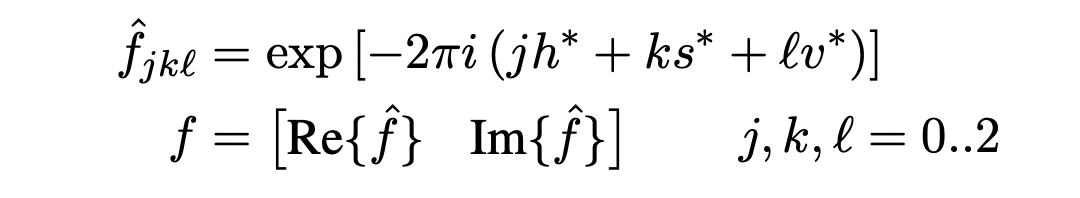

In [200]:
def represent_color_context(colors):
    return [represent_color(color) for color in colors]
def represent_color(color):
    
    
    # BEGIN SOLUTION

    h, s, v = colorsys.rgb_to_hsv(*colorsys.hls_to_rgb(*color))
    fourier = [] #np.zeros(54)
    for j in range(3):
      for k in range(3):
        for l in range(3):
          f = np.exp(-2*np.pi*1j *(j*h + k*s + l*v))
          f = [np.real(f), np.imag(f)] #all real, all imaginary does not work
          fourier.extend(f)
    return fourier
    # END SOLUTION



    

def test_represent_color_context(func):
    """`func` should be `represent_color_context`"""
    example = [
        [0.786, 0.58, 0.87],
        [0.689, 0.44, 0.92],
        [0.628, 0.32, 0.81]]
    result = func(example)
    assert len(result) == len(example), \
        ("Color context representations need to represent each color "
         "separately. (We assume the final color is the target.)")
    for i, color in enumerate(result):
        assert all(isinstance(x, float) for x in color), \
            ("All color representations should be lists of floats. "
             "Color {} is {}".format(i, color))
        
test_represent_color_context(represent_color_context)

In [207]:
dev_cols_train = [represent_color_context(colors) for colors in dev_rawcols_train]
dev_cols_test = [represent_color_context(colors) for colors in dev_rawcols_test]

With the improved model, training tends to last for more epochs before early stopping kicks in. The following code should take about five minutes to run, although there could be some variation depending on how you implemented the tokenization and color models:

In [208]:
dev_mod = ContextualColorDescriber(dev_vocab, early_stopping=True)
%time _ = dev_mod.fit(dev_cols_train, dev_seqs_train)

Stopping after epoch 124. Validation score did not improve by tol=1e-05 for more than 10 epochs. Final error is 15.474966287612915

CPU times: user 4min 40s, sys: 834 ms, total: 4min 41s
Wall time: 4min 45s


##### 

Our reference implementation achieves a listener accuracy of 0.77 and a BLEU of 0.69. You may see some variation from these numbers, but you should aim to achieve listener accuracy above 0.7 and BLEU above 0.6 for full credit. Alternatively, you may achieve full credit by 

In [210]:
evaluation = dev_mod.evaluate(dev_cols_test, dev_seqs_test)
print("Listener accuracy (improved): {}".format(evaluation['listener_accuracy']))
print("BLEU (improved): {}".format(evaluation['corpus_bleu']))


Listener accuracy (improved): 0.7463768115942029
BLEU (improved): 0.687389369100563


WORD LENGTH + ALL: Listener accuracy (improved): 0.8042038583357328
BLEU (improved): 0.6891308745806776

MOST COMMON: Listener accuracy (improved): 0.7658514492753623
BLEU (improved): 0.6640120008293773

HSV DCT: Listener accuracy (improved): 0.6956521739130435
BLEU (improved): 0.6004246663224859

CMYK FFT:
Listener accuracy (improved): 0.3845108695652174
BLEU (improved): 0.5455344018617262

CMYK:
Listener accuracy (improved): 0.761322463768116
BLEU (improved): 0.6449453528586643

POS:
Listener accuracy (improved): 0.7463768115942029
BLEU (improved): 0.687389369100563









You can also print out some example generations from the model:

In [ ]:
evaluation["predicted_utterance"]

## Report: Further Experimentation

Once you've got a working model, there are several opportunities for further analysis and experimentation with this dataset. Please consider any of the following tasks and write a one-page report detailing your experiments:
* Conduct a thorough analysis of alternative methods for tokenization and color representation
* Replace the argmax in the prediction code with a sampling-based inference procedure, and sample 5-10 possible candidate descriptions for each of a handful of examples. Then rank these examples based on listener accuracy. Do the rankings align with your intuitions?
* Experiment with manually changing the color contexts to see whether or not this affects generated text. If it doesn't, can you modify the model so that it could? Provide some discussion of how you should expect specific color descriptions to change in different contexts.
* Use the "far," "split," and "close" conditions to evaluate how well your model performs under different conditions. Can you retrain the model on the whole dataset (or a different subset) to make it perform better at the "close" condition?
* *Advanced*: This assignment is based on a [bakeoff](https://github.com/cgpotts/cs224u/blob/master/hw_colors.ipynb) in the Stanford's CS224U course, taught by Chris Potts. Complete challenge #4 from the bakeoff, which involves feeding color embeddings into the decoder at each step of the inference procedure
* *Advanced*: Run the code with Mandarin data from [Monroe, et al. (2018)](https://aclanthology.org/N18-1196.pdf)

Please also state what final accuracies your system achieved. Feel free to come up with your own ideas for the report as well!

###RANDOM CODE FOR EXPERIMENTS - NOT FINAL

In [37]:
"""YOUR CODE HERE"""
# BEGIN EXPERIMENTS
def represent_color(color): #from monroe
  color = [*colorsys.hls_to_rgb(*color)]
  ranges = (256.0, 256.0, 256.0)
  resolution = [10, 10, 10]
  colors_internal = np.minimum(color, ranges - 1e-4)
  bucket_sizes = tuple(d / r for d, r in zip(ranges, resolution))
  bucket_dims = (colors_internal // np.array(bucket_sizes)).astype(np.int32)
  result = (bucket_dims[..., 0] * resolution[1] * resolution[2] +
                  bucket_dims[..., 1] * resolution[2] +
                  bucket_dims[..., 2])
  return result
# END EXPERIMENTS

In [112]:
from scipy.fftpack import fft, dct
def represent_color(color):
  h, s, v, k = rgb_to_cmyk(*colorsys.hls_to_rgb(*color))
  fourier = [] #np.zeros(54)
  for j in range(4):
      for k in range(4):
        for l in range(4):
          f = np.exp(-2*np.pi*1j *(j*h + k*s + l*v))
          f = [np.real(f), np.imag(f)] #all real, all imaginary does not work
          fourier.extend(f)
  return fourier


In [91]:
from scipy.fftpack import fft, dct
def represent_color(color):
  #color = [*colorsys.rgb_to_hsv(*colorsys.hls_to_rgb(*color))]
  #cosine = [] #np.zeros(54)
  return dctr(color)

In [70]:
def rgb_to_cmyk(r, g, b): 
    CMYK_SCALE = 100

   
    c = 1 - r / 255
    m = 1 - g / 255
    y = 1 - b / 255

    min = np.min(c, m, y)
    c = (c - min)*100 / (1 - min)
    m = (m - min)*100 / (1 - min)
    y = (y - min)*100 / (1 - min)
    k = min

    return c,m,y,k

In [103]:
def dctr(color):
  h, s, v = colorsys.rgb_to_hsv(*colorsys.hls_to_rgb(*color))
  cos =[]
  for j in range(3):
    for k in range(3):
      for l in range(3):
        #f = np.cos((2*h+1)*j*np.pi/2) * np.cos((2*s+1)*k*np.pi/2) * np.cos((2*v+1)*l*np.pi/2) #wrong
        cos.append(f)
  return cos